# Spam Detection - NLP 662

### by Cameron Wood and Tom el Safadi

- This project is a spam detection model that leverages a bidirectional LSTM to output a binary classification for either 1 - spam, or 0 - not spam (called "ham"). The binary classification is a softmax layer but we use ReLU in order to handle the vanishing gradient problem.

- We'll leverage the keras Tokenizer for handling our vocabulary and unique tokens internally. Then, we pad the tokens so that they are all the same length and normalized. This will be fed into an Embedding layer to vectorize our tokens before we finally begin training.

In [1]:

import os
import sys
import re
import glob
import email
import string


import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model

!{sys.executable} -m pip install seaborn > /dev/null # I don't care about seeing this output
import seaborn as sns


# Download and unpack datasets

 - All of our datasets came from https://spamassassin.apache.org/old/publiccorpus/. Please run the below cell in order to download, unpack and move files to the appropriate directory before continuing.

In [2]:
!rm -rf spam_data
!mkdir -p spam_data

!wget https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20050311_spam_2.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2
    
!tar xvjf 20030228_easy_ham_2.tar.bz2 > /dev/null  # I don't care about seeing this output
!tar xvjf 20030228_easy_ham.tar.bz2 > /dev/null  # I don't care about seeing this output
!tar xvjf 20030228_hard_ham.tar.bz2 > /dev/null  # I don't care about seeing this output
!tar xvjf 20030228_spam.tar.bz2 > /dev/null  # I don't care about seeing this output
!tar xvjf 20050311_spam_2.tar.bz2 > /dev/null  # I don't care about seeing this output

!rm 20030228_easy_ham.tar.bz2
!rm 20030228_easy_ham_2.tar.bz2
!rm 20030228_hard_ham.tar.bz2
!rm 20030228_spam.tar.bz2
!rm 20050311_spam_2.tar.bz2

!mv easy_ham spam_data
!mv easy_ham_2 spam_data
!mv hard_ham spam_data
!mv spam spam_data
!mv spam_2 spam_data

print("Done")

--2021-11-28 19:07:02--  https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1612216 (1.5M) [application/x-bzip2]
Saving to: ‘20030228_easy_ham.tar.bz2’

100%[======================================>] 1,612,216   --.-K/s   in 0.09s   

2021-11-28 19:07:02 (17.6 MB/s) - ‘20030228_easy_ham.tar.bz2’ saved [1612216/1612216]

--2021-11-28 19:07:02--  https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1077892 (1.0M) [application/x-bzip2]
Saving to: ‘20030228_easy_

# Functions to read and prepare data

- `all_datasets_exist()` checks that the files are downloaded and unpacked. Run above cell if not.
- `read_email()` reads the raw content of an email given its file path.
- `get_email_content()` is a wrapper that uses read_email on all emails.
- `remove_null()` is used to remove an email object that has no content. This is done after reading all the emails because we need to remove the given y label associated with it.
- `prepare_datasets()` is the beginning of the pipeline before we start cleaning/tokenizing/padding. This function will leverage all of the functions mentioned above.

In [3]:
def all_datasets_exist() -> bool:
    """

    Function that checks for all the expected spam datasets to be unpacked.

    Params:
        - None

    Returns:
        - True or False

    """

    expected_dirs = ["easy_ham", "easy_ham_2", "hard_ham", "spam", "spam_2"]
    folder = "./spam_data/"

    for dir_name in expected_dirs:
        path = folder + dir_name
        if not os.path.exists(path):
            return False
    return True

def read_email(path):
    """
    Raed the raw content from an email.

    Params:
     - path (str): the file path for the email to read.
    
    Returns:
     - content (str): raw content of an email.
    """
    file = open(path, encoding="latin1")
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == "text/plain":
                return part.get_payload()  # raw text
    except Exception as e:
        print(e)
    

def get_email_content(email_paths):
    """
    Wrapper for aggregating email content on all files.

    Params:
     - email_paths (list): list of email paths to read.

    Returns:
     - content (list): list of email content. 
    """
    content = [read_email(path) for path in email_paths]
    return content


def remove_null(datasets, labels):
    """
    Sometimes email content is empty when we receive it. We can't remove it as we
    read the email becuase we have a matching y_label unpacked already and we need
    to remove them at the same time.

    Params:
     - datasets (list): Raw emails to be evaluated.
     - labels: (list): 1/0 y_label of the emails from dataset.
    
    Returns:
     - (datasets, labels): removed of any null content
    """
    not_null_idx = [i for i, o in enumerate(datasets) if o is not None]
    return np.array(datasets)[not_null_idx], np.array(labels)[not_null_idx]


def prepare_datasets():
    """
    Start of the SpamDetection pipeline which involves actually unpacking and splitting
    the datasets into train and test data. You'll need to make sure to unpack the tar files
    inside the spam_data directory (see the function `all_datasets_exist` for more detail).

    Params:
     - None

     Returns:
     - 4-tuple of train/test datasets with y labels.
    """
    
    if not all_datasets_exist():
        print("Please run the above cell.")
    print("Training/test datasets are loaded and ready!")

    # gather all file names unpacked
    path = "./spam_data/"
    ham_files = [
        glob.glob(path + "easy_ham/*"),
        glob.glob(path + "easy_ham_2/*"),
        glob.glob(path + "hard_ham/*"),
    ]
    spam_files = [glob.glob(path + "spam/*"), glob.glob(path + "spam_2/*")]

    ham_sample = np.array([train_test_split(o) for o in ham_files], dtype=object)

    ham_train = np.array([])
    ham_test = np.array([])
    for o in ham_sample:
        ham_train = np.concatenate((ham_train, o[0]), axis=0)
        ham_test = np.concatenate((ham_test, o[1]), axis=0)

    spam_sample = np.array([train_test_split(o) for o in spam_files], dtype=object)

    spam_train = np.array([])
    spam_test = np.array([])
    for o in spam_sample:
        spam_train = np.concatenate((spam_train, o[0]), axis=0)
        spam_test = np.concatenate((spam_test, o[1]), axis=0)

    # attach labels to data (0 - ham, 1 - spam)
    ham_train_label = [0] * ham_train.shape[0]  # type: ignore
    spam_train_label = [1] * spam_train.shape[0]  # type: ignore
    ham_test_label = [0] * ham_test.shape[0]  # type: ignore
    spam_test_label = [1] * spam_test.shape[0]  # type: ignore

    x_test = np.concatenate((ham_test, spam_test))
    y_test = np.concatenate((ham_test_label, spam_test_label))
    x_train = np.concatenate((ham_train, spam_train))
    y_train = np.concatenate((ham_train_label, spam_train_label))

    # shuffle
    train_shuffle_index = np.random.permutation(np.arange(0, x_train.shape[0]))  # type: ignore
    test_shuffle_index = np.random.permutation(np.arange(0, x_test.shape[0]))  # type:ignore

    x_train = x_train[train_shuffle_index]
    y_train = y_train[train_shuffle_index]

    x_test = x_test[test_shuffle_index]
    y_test = y_test[test_shuffle_index]

    # email content for training
    x_train = get_email_content(x_train)
    x_test = get_email_content(x_test)

    x_train, y_train = remove_null(x_train, y_train)
    x_test, y_test = remove_null(x_test, y_test)

    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = prepare_datasets()

Training/test datasets are loaded and ready!


# Cleaning, Tokenizing and Padding data

In [4]:
def preprocess_clean(data):
    """
    Do some preprocess cleaning with the data from emails. We want to do some
    normalization so there is no bias for certain anomalies within the data.

    Params:
     - data (str): The raw content of an email

    Returns:
     - data (str): normalized and clean data
    """

    data = data.replace("\n", "").lower().strip()
    data = re.sub(r"http\S+", "", data)  # no hyperlink
    data = re.sub(r'\d+', '', data) # no numbers
    data = data.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return data


def tokenize_and_pad(x_train, x_test):
    """
    Use Keras tokenizer on train and test datasets. Pad these tokens so 
    that all are the same length before turning them into vectors.
    """
    max_feature = 50000  # how many unique words
    max_len = 2000 # max number of words

    tokenizer = Tokenizer(num_words=max_feature)

    tokenizer.fit_on_texts(x_train)
    x_train_features = np.array(tokenizer.texts_to_sequences(x_train), dtype=object)
    x_test_features = np.array(tokenizer.texts_to_sequences(x_test), dtype=object)

    x_train_features = pad_sequences(x_train_features,maxlen=max_len)
    x_test_features = pad_sequences(x_test_features,maxlen=max_len)

    return x_train_features, x_test_features



x_train = [preprocess_clean(o) for o in x_train]
x_test = [preprocess_clean(o) for o in x_test]

x_train_features, x_test_features = tokenize_and_pad(x_train, x_test)



# Build the model
 - This is a bidirectional LSTM to output a binary classification for either 1 - spam, or 0 - not spam (called "ham"). The binary classification is a softmax layer but we use ReLU in order to handle the vanishing gradient problem. We'll use adam optimizer for our gradient descent and cross entropy as our loss function.

In [5]:
def create_model():
   
    max_feature = 50000  # how many unique words
    max_len = 2000 # max number of words
    embedding_vecor_length = 32

    model = tf.keras.Sequential()
    model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # print(model.summary())
    return model


# Train the model

In [6]:
def train_model(model):

    history = model.fit(
        x_train_features,
        y_train,
        batch_size=512,
        epochs=20,
        validation_data=(x_test_features, y_test)
    )
    print("Finished training!")



# Matplot of accuracy

In [7]:
def printPlot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

# Confusion Matrix Heatmap

In [8]:

def printConfusionMatrix(y_test, y_predict):
    cf_matrix = confusion_matrix(y_test, y_predict)
    
    ax = plt.subplot()
    sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])

In [9]:
def printScores(y_test, y_predict):
    tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()
    print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
    print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))
    print("F1 Score: {:.2f}%".format(100 * f1_score(y_test,y_predict)))

# Entrypoint of code
 - This is where the code starts and will execute the functions above.
 - It will train the model as well as print out some analysis.

Training/test datasets are loaded and ready!
Epoch 1/20
8/8 [==============================] - 57s 7s/step - loss: 0.6731 - accuracy: 0.7473 - val_loss: 0.6300 - val_accuracy: 0.7984
Epoch 2/20
8/8 [==============================] - 53s 7s/step - loss: 0.5668 - accuracy: 0.7927 - val_loss: 0.5058 - val_accuracy: 0.7984
Epoch 3/20
8/8 [==============================] - 53s 7s/step - loss: 0.5100 - accuracy: 0.7924 - val_loss: 0.4816 - val_accuracy: 0.7984
Epoch 4/20
8/8 [==============================] - 52s 6s/step - loss: 0.4728 - accuracy: 0.7924 - val_loss: 0.4113 - val_accuracy: 0.7984
Epoch 5/20
8/8 [==============================] - 54s 7s/step - loss: 0.3502 - accuracy: 0.8058 - val_loss: 0.2484 - val_accuracy: 0.9020
Epoch 6/20
8/8 [==============================] - 57s 7s/step - loss: 0.2199 - accuracy: 0.9423 - val_loss: 0.1789 - val_accuracy: 0.9439
Epoch 7/20
8/8 [==============================] - 55s 7s/step - loss: 0.1347 - accuracy: 0.9672 - val_loss: 0.1190 - val_accura

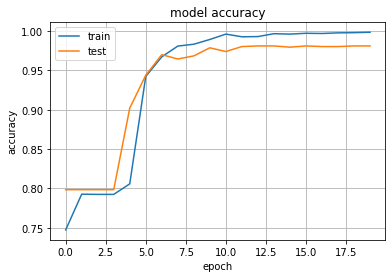

Precision: 95.65%
Recall: 94.90%
F1 Score: 95.28%


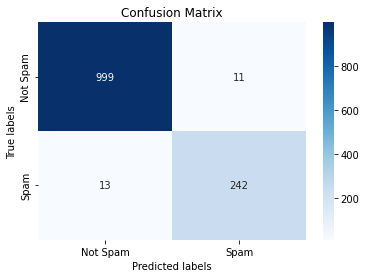

In [10]:
def main():
    x_train, y_train, x_test, y_test = prepare_datasets()
    x_train = [preprocess_clean(o) for o in x_train]
    x_test = [preprocess_clean(o) for o in x_test]

    x_train_features, x_test_features = tokenize_and_pad(x_train, x_test)

    model = create_model()
    
    history = model.fit(
        x_train_features, y_train, batch_size=512, epochs=20, validation_data=(x_test_features, y_test))
    
    y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]
    
    printPlot(history)
    printConfusionMatrix(y_test, y_predict)
    printScores(y_test, y_predict)
    
    f1_score(y_test, y_predict)
    
main()